# Capstone Project - The Battle of the Neighborhoods (Week 2)

### Applied Data Science Capstone by IBM/Coursera
####By: Matt Peddle
####Completed Feb 7, 2020


# Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction: Business Problem

**TouchBistro Inc**. is a **Toronto**-based software company that develops a restaurant point of sale system for the iPad and named Best POS System for Restaurants by Business News Daily. As head of sales, it is my duty to find and contact leads specifically in the restaurant field. 

Internally within TouchBistro, I have discovered the profitability of an account is determined by the following:

* How busy they are
* Size of the restaurant (seating room)
* Average bill price (menu items)

In this report, I will analyze and map out potential new clients accounting for the above information. In addition, I will go one step further and highlight our current clients within a certain proximity, so when contacting these new restaurants I'll be able to reference happy current clients. 

## Data <a name="data"></a>

# Based on the definition of our problem, the factors that will influence our decision are:

* Number of existing restaurants in the neighborhood (any type of restaurant)
* Distance of neighborhood from city center
* Average spend per customer


Following data sources will be needed to extract/generate the required information:

* **Google Maps API reverse geocoding** will provide the mapping, approximate addresses of venues, busyness functional data. 
* **Foursquare API** will provide us with the venue names, restaurant types and their type and location in every neighborhood.  
* **Zomato API** To assist in providing additional information such as average spend and to verify Foursquare data will be using Zomato as they specialize in restaurant data. 

# Libraries we will be using:

* Python 3: Main coding language
* Pandas: Data Analysis
* Numpy: Handel data in a vectorized manner
* Random: Random number generation
* Conda: GeoCoders - converting addresses into latitude and longitude values
* Folium: Visualizing our data with maps.  
* Matplotlib: Mapping

# Exploring venues in Toronto Canada


In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

/bin/bash: conda: command not found
/bin/bash: conda: command not found
Folium installed
Libraries imported.


I will use the folium library to create a complete map zoomed in on Toronto.

# Foursquare API 

In [2]:
@hidden_page
CLIENT_ID = 'KQIVOQL3S1VCZSCYCSNFC2BGX0TMMRQ3HS04VGPJG05CJXDL' # your Foursquare ID
CLIENT_SECRET = 'FWZWNSSUARUFTQEMHIZW44T5XJWAAHTCEIBDUC1OCKLKFYBX' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KQIVOQL3S1VCZSCYCSNFC2BGX0TMMRQ3HS04VGPJG05CJXDL
CLIENT_SECRET:FWZWNSSUARUFTQEMHIZW44T5XJWAAHTCEIBDUC1OCKLKFYBX


In [3]:
address = 'Toronto'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.653963 -79.387207


In [0]:
# for mapping we will use Folium
import folium

m = folium.Map(location=[43.653963, -79.387207])


In [0]:
# We define the get_category_type method to get the correct category for each venue. We can come and change this to an alternative venue if we wish to furth narrow down our serach, but as we don't know how many businesses will be listed on Foursquare and Zomoto its best to expand our search for now. 
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.
* Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.
* We will set the radius as 40 Kilometers.

In [0]:
@hidden
FOURSQUARE_CLIENT_ID = 'KQIVOQL3S1VCZSCYCSNFC2BGX0TMMRQ3HS04VGPJG05CJXDL'
FOURSQUARE_CLIENT_SECRET = 'FWZWNSSUARUFTQEMHIZW44T5XJWAAHTCEIBDUC1OCKLKFYBX'
RADIUS = 4000 # 20 Km
NO_OF_VENUES = 1000
VERSION = '20190612' # Current date

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        latitude, 
                                                                        longitude, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/100))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 40.0 Km
Total 100 venues fetched within a total radius of 40.0 Km
Total 43 venues fetched within a total radius of 40.0 Km

Total 243 venues fetched


# Zomato API



The Zomato API allows us to search for any given venue based on certain search filters such as query, latitude, longitude and more. 

Zomato also requires a Zomato user key which can be accessed with a developer account.

Get Key: https://developers.zomato.com/api

In [8]:
headers = {'user-key': 'Zomato-API-KEY'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

# Data Cleaning ¶


Data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [9]:
toronto_map = folium.Map(location=[43.653963, -79.387207],tiles='Stamen Toner', zoom_start=13)


for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(toronto_map)  

toronto_map.save("/content/Venues by Foursquare.html")
toronto_map

From the map, we can see that although the dots are spread out over the city, there does seem to be some bunching which we will explore further. 

We will also plot the Zomato data on the map.

I added the following code snippet I found after a long search as I was getting the following error. 

***"RecursionError: maximum recursion depth exceeded in comparison"***

In [2]:
import sys 
sys.setrecursionlimit(10**6) 
def fact(n): 
  
    if(n == 0): 
        return 1
  
    return n * fact(n - 1) 
  
if __name__ == '__main__': 
  
    # taking input 
    f = int(input('Enter the number: \n')) 
  
    print(fact(f)) 


Enter the number: 
1
1


In [63]:

toronto_map = folium.Map(location=[43.653963, -79.387207],tiles='Stamen Toner', zoom_start=13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], zomato_venues['latitude'],zomato_venues['longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(toronto_map)  

toronto_map.save("/content/Venues by Zomato.html")
toronto_map

The Red dots show our Zomato venues and comparing this with our earlier Foursquare (green dots we can see this additional API will provide some much-needed data. 

In [0]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [0]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [66]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Nathan Phillips Square,Plaza,43.6523,-79.3835,Hero Certified Burgers,43.6522,-79.3839,25.0,1.0,0,"Nathan Phillips Square, 100 Queen Street West,...",-0.0001,-0.0004
1,Shangri-La Toronto,Hotel,43.6491,-79.3866,Momofuku Daishō,43.6494,-79.3864,80.0,3.0,3.6,"Momofuku, Third Floor, 190 University Avenue, ...",0.0003,0.0002
2,Pai,Thai Restaurant,43.6479,-79.3886,Pai,43.6479,-79.3888,50.0,2.0,4.9,"18 Duncan Street, Toronto",0.0000,-0.0002
3,Rosalinda,Vegetarian / Vegan Restaurant,43.6503,-79.3852,Rosalinda,43.6502,-79.3848,50.0,2.0,3.2,"133 Richmond St W Toronto, ON",-0.0001,0.0004
4,Byblos Toronto,Mediterranean Restaurant,43.6476,-79.3884,Byblos,43.6475,-79.3883,90.0,3.0,4.4,11 Duncan Street M5V 3M2,-0.0001,0.0001
5,Soho House Toronto,Speakeasy,43.6487,-79.3865,Elephant & Castle,43.6483,-79.3863,85.0,3.0,3.8,"212 King Street West, Toronto M5H 1K5",-0.0004,0.0002
6,The Keg Steakhouse + Bar,Steakhouse,43.6499,-79.3842,The Keg,43.6496,-79.3840,100.0,4.0,4.1,"165 York Street, Financial District, Toronto M...",-0.0003,0.0002
7,Richmond Station,American Restaurant,43.6516,-79.3793,Sunset Grill,43.6515,-79.3792,30.0,2.0,3.9,"1 Richmond Street West, Toronto",-0.0001,0.0001
8,Jimmy's Coffee,Coffee Shop,43.6584,-79.3856,Jimmy's Coffee,43.6583,-79.3857,15.0,1.0,3.6,"84 Gerrard Street West, Toronto M5G 1Z4",-0.0001,-0.0001
9,Banh Mi Boys,Sandwich Place,43.6593,-79.3819,Banh Mi Boys,43.6589,-79.3822,25.0,1.0,4.3,"399 Yonge Street, Toronto",-0.0004,-0.0003


Are Frankenstein lists isn't that bad actually. There are some issues where a location has more than classifications, but we can clean that up in the next line.

In [0]:
# selected_venues = selected_venues.drop([0, 20, 25, 29, 32, 34, 47, 49, 56, 57, 58, 59, 60, 64]).reset_index(drop = True)

We will average the price per person by dividing the column price_for_two by 2 and removing this column from the dataset along with other unnecessary columns.

In [0]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

Let's take a look at the final dataset that is left with us.


In [68]:
selected_venues.head(250)


,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Plaza,Hero Certified Burgers,43.6522,-79.3839,1.0,0,"Nathan Phillips Square, 100 Queen Street West,...",12.5
1,Hotel,Momofuku Daishō,43.6494,-79.3864,3.0,3.6,"Momofuku, Third Floor, 190 University Avenue, ...",40.0
2,Thai Restaurant,Pai,43.6479,-79.3888,2.0,4.9,"18 Duncan Street, Toronto",25.0
3,Vegetarian / Vegan Restaurant,Rosalinda,43.6502,-79.3848,2.0,3.2,"133 Richmond St W Toronto, ON",25.0
4,Mediterranean Restaurant,Byblos,43.6475,-79.3883,3.0,4.4,11 Duncan Street M5V 3M2,45.0
5,Speakeasy,Elephant & Castle,43.6483,-79.3863,3.0,3.8,"212 King Street West, Toronto M5H 1K5",42.5
6,Steakhouse,The Keg,43.6496,-79.3840,4.0,4.1,"165 York Street, Financial District, Toronto M...",50.0
7,American Restaurant,Sunset Grill,43.6515,-79.3792,2.0,3.9,"1 Richmond Street West, Toronto",15.0
8,Coffee Shop,Jimmy's Coffee,43.6583,-79.3857,1.0,3.6,"84 Gerrard Street West, Toronto M5G 1Z4",7.5
9,Sandwich Place,Banh Mi Boys,43.6589,-79.3822,1.0,4.3,"399 Yonge Street, Toronto",12.5


We have a total of 148 Venues.

# Methodology

This project aims at identifying potential business we could sell our POS payment system to.  We know from our current clients some basic information which we attempted to generate such as (location, type of venue (resturants), high spend ($30 per person), and as a general rule we can determine is a venue has a high/good rating that there should be more foot traffic and thus more opportunities for a business to need our payment system.

We have zeroed in on Toronto as this is are hypothetical sales territory. As our territory is Toronto we have focused our efforts on this city. 

In the first step, we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information from the city of Toronto, up to a distance of 40 Km. The latitude and longitude values are then used to fetch venue ratings and price from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. (originally we only wanted to focus on restaurants but we found that many restaurants where actually classifies as hotels or other venues. This does make sense as Toronto is a tourist city and a lot of sales happen at the hotel lobby bars. An area we are keen to focus on.

The final dataset will include the rating and price values for each venue. Next, we'll analyze the data that we created based on the ratings and prices of each venue. We'll identify places where many venues are located so that we can focus our marketing and on foot sales efforts more effectively. 

Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues we should focus our sales efforts on. 

Finally, we'll discuss and conclude which within our sales presentation on the overall expected ROI and highlight our findings. 

# Analysis

The complete dataset is now in its final form.

We will inspect these venues based on their rating. The rating of a venue is based on user reviews and belongs to a range from 1 to 5. We'll also analyze the venues based on their price per person as well as the price range.

**Categories**

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 58 artists>

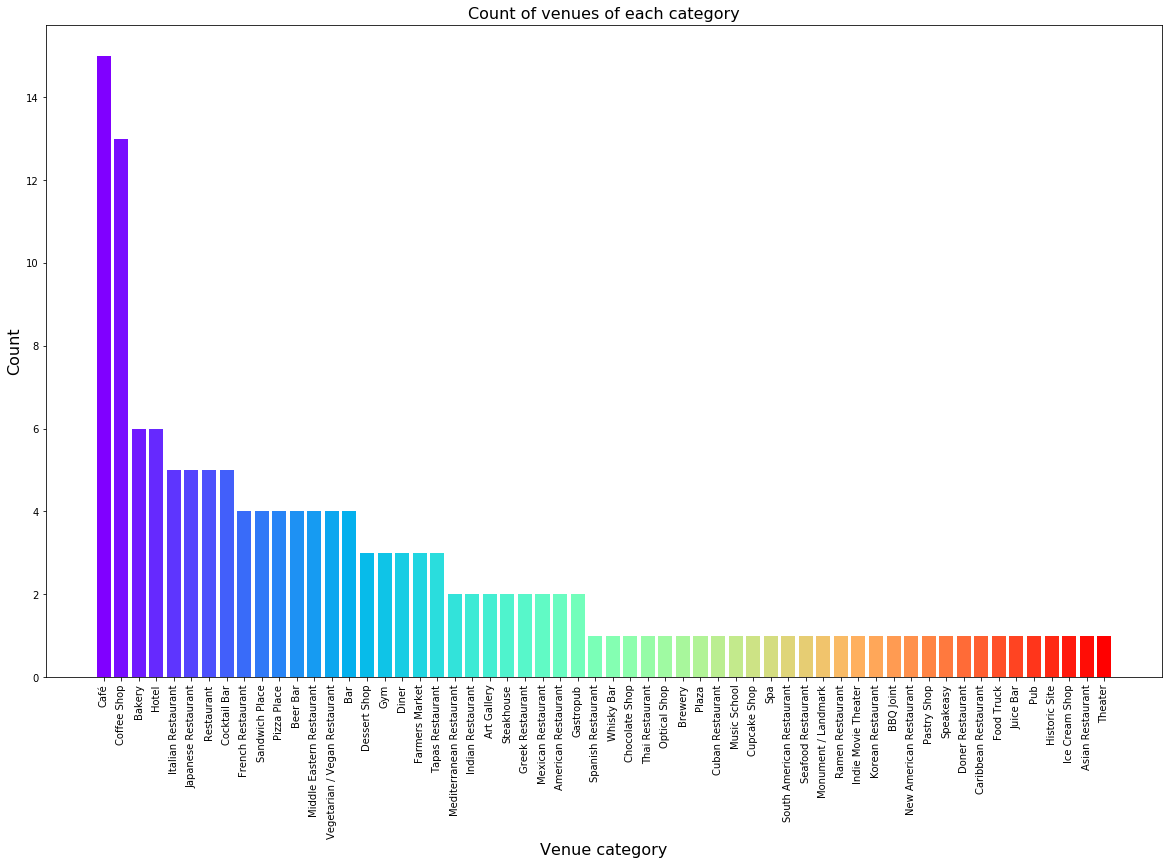

In [69]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are Cafe and Hotels. This isn't the best news for us as coffee shops have an average spend of 10 dollars and under. However, as we have seen in our data **Hotels also include restaurants where an average spend per person is over $40** and there is traffic at all hours providing a steady flow of card swiping customers. 


**Rating**

The rating of a venue is an important factor as we have mentioned previously the higher the rating the more likely there will be more customers and thus more card swipes where we can make money. 

Google does offer an API to gain greater insight into the live busy times but this service is rather expensive at this time.

Venues with a higher rating are something we want to focus on but perhaps some bad reviews may stem from the business's inability to accept a customer preferred payment method. 

This is something we would like to know so we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

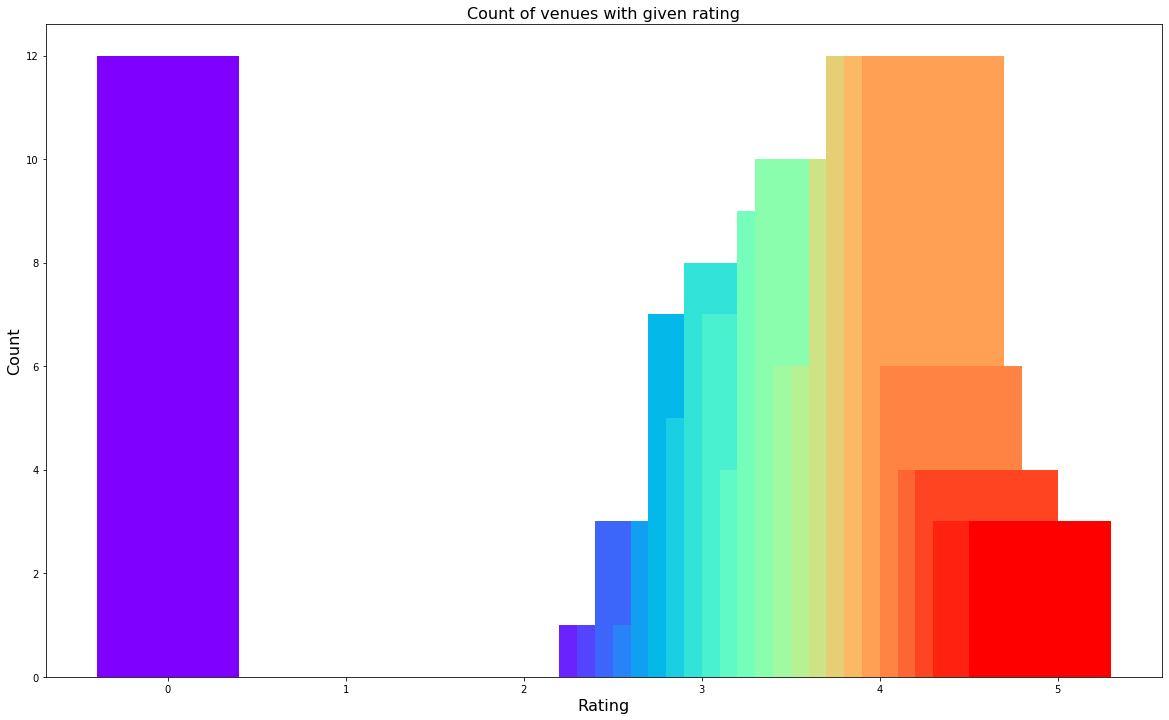

In [70]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

We can see that many venues are not rated but the ones that are, are around the 4 marks. Showings Canadians once again are too kind :)

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided into 4 bins:

* 0 to 2
* 2 to 3
* 3 to 4
* 4 to 5

In [0]:
bins = [0.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)


Now, we will plot the venues on the map.


In [74]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}
toronto_map = folium.Map(location=[43.653963, -79.387207], zoom_start=13)


for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(toronto_map)  

toronto_map.save("/content/Venues Ratings.html")
toronto_map


#Price
We will now take a look at the venues based on the price points. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

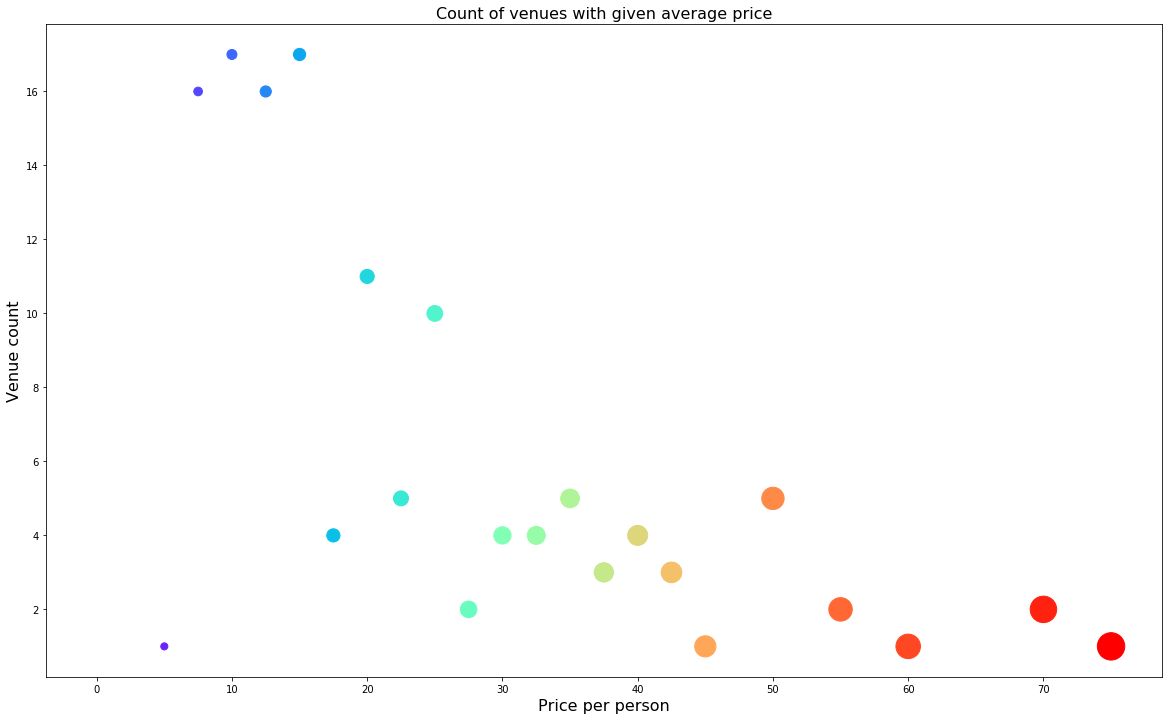

In [37]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a large number of venues have an average price between $8 and $20 per person. for our Sales efforts we also see a smaller number of venues with a much higher average spend. 


In [42]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

toronto_map = folium.Map(location=[43.653963, -79.387207],tiles='Stamen Toner', zoom_start=13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(toronto_map)  

toronto_map.save("/content/Venues Prices.html")
toronto_map

Prices seem to fluctuate widely across the city but we do see that there are appears to be a collection of **red dots on the upper east side of the city.** Perhaps it may be worthy of a sales rep to spend some time capsizing the area. 

**Clustering**

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [43]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Hotel,Momofuku Daishō,43.6494,-79.3864,3.0,3.6,"Momofuku, Third Floor, 190 University Avenue, ...",40.0,Good
1,0,Thai Restaurant,Pai,43.6479,-79.3888,2.0,4.9,"18 Duncan Street, Toronto",25.0,Very good
2,0,Vegetarian / Vegan Restaurant,Rosalinda,43.6502,-79.3848,2.0,3.2,"133 Richmond St W Toronto, ON",25.0,Good
3,1,Mediterranean Restaurant,Byblos,43.6475,-79.3883,3.0,4.4,11 Duncan Street M5V 3M2,45.0,Very good
4,1,Speakeasy,Elephant & Castle,43.6483,-79.3863,3.0,3.8,"212 King Street West, Toronto M5H 1K5",42.5,Good


In [44]:
toronto_map = folium.Map(location=[43.653963, -79.387207],tiles='Stamen Toner', zoom_start=13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(toronto_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(toronto_map)

toronto_map.save("/content/Venues Clusters.html")
toronto_map

From the map, we see the two clusters which seem to somewhat seperated by North and South. 

It appears that the south central venues are a bit more pricy then other areas.

I'll also check the venues of the two clusters.

In [45]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Thai Restaurant,Pai,43.6479,-79.3888,2.0,4.9,"18 Duncan Street, Toronto",25.0,Very good
1,0,Vegetarian / Vegan Restaurant,Rosalinda,43.6502,-79.3848,2.0,3.2,"133 Richmond St W Toronto, ON",25.0,Good
2,0,American Restaurant,Sunset Grill,43.6515,-79.3792,2.0,3.9,"1 Richmond Street West, Toronto",15.0,Good
3,0,Coffee Shop,Jimmy's Coffee,43.6583,-79.3857,1.0,3.6,"84 Gerrard Street West, Toronto M5G 1Z4",7.5,Good
4,0,Sandwich Place,Banh Mi Boys,43.6589,-79.3822,1.0,4.3,"399 Yonge Street, Toronto",12.5,Very good
5,0,Theater,Tim Hortons,43.6537,-79.3787,1.0,2.8,"30 Bond Street, Inside St. Michael's Hospital,...",10.0,Okay
6,0,Gym,Sud Forno,43.6512,-79.3780,1.0,3.1,"132 Yonge Street, Financial District, Toronto ...",10.0,Good
7,0,Gym,Mrs. Fields,43.6481,-79.3801,1.0,2.6,"Commerce Court, 199 Bay Street, The PATH, Toronto",7.5,Okay
8,0,Art Gallery,Mamma's Pizza,43.6477,-79.3954,1.0,3.3,"405 Richmond Street West, Toronto",12.5,Good
9,0,Sandwich Place,Banh Mi Boys,43.6487,-79.3970,1.0,4.9,"392 Queen Street West, Toronto",12.5,Very good


In [49]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.49 and rating spread around 3.33


In [51]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(250).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Hotel,Momofuku Daishō,43.6494,-79.3864,3.0,3.6,"Momofuku, Third Floor, 190 University Avenue, ...",40.0,Good
1,1,Mediterranean Restaurant,Byblos,43.6475,-79.3883,3.0,4.4,11 Duncan Street M5V 3M2,45.0,Very good
2,1,Speakeasy,Elephant & Castle,43.6483,-79.3863,3.0,3.8,"212 King Street West, Toronto M5H 1K5",42.5,Good
3,1,Steakhouse,The Keg,43.6496,-79.3840,4.0,4.1,"165 York Street, Financial District, Toronto M...",50.0,Very good
4,1,French Restaurant,Alo Restaurant,43.6485,-79.3960,4.0,4.1,"163 Spadina Avenue, 3rd Floor, Toronto M5V 2L6",50.0,Very good
5,1,Restaurant,Aloette,43.6485,-79.3959,3.0,3.3,163 Spadina Avenue M5V 2L6,30.0,Good
6,1,Hotel,Ritz Bar,43.6454,-79.3872,4.0,3.3,181 Wellington Street West M5V 3G7,50.0,Good
7,1,Restaurant,George Restaurant,43.6533,-79.3745,4.0,4.3,"111C Queen Street East, Toronto M5C 1S2",55.0,Very good
8,1,Gastropub,Beerbistro,43.6494,-79.3773,3.0,4.4,"18 King Street East, Toronto M5C 1C4",40.0,Very good
9,1,Hotel,Citrus - The Grand Hotel & Suites,43.6566,-79.3737,4.0,3.4,"The Grand Hotel & Suites, 225 Jarvis Street, T...",70.0,Good


In [52]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 3.31 and rating spread around 4.06


# Results and Discussion ¶

Based on our analysis above, we can draw a number of conclusions that will be useful to aid with our sales and marketing efforts in the city of Toronto, Canada.

After collecting data from the Foursquare and Zomato APIs, we got a list of 250 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 134.

While the complete range of ratings ranges from 0 to 5, the majority of venues have ratings close to 4. This means that most venues should have high traffic and will process more payments.

When we take a look at the price values of each venue, we explore that many venues have prices that are in the range of **15 dollars and under per person**. However, the variation in prices is very large, given the complete range starts from **$15 and surpasses the 100 dollars per person**. On plotting the venues based on their price range on the map, we discovered that venues located with the upper east side of the city are relatively priced higher than other areas. 

Finally, through clusters, pricing, and ratings we have **discovered a new sweet spot with Hotel Resturants.** As they possess the potential for the highest profits potential for us. This isn't all as hotel restaurants are located within hotels we can assume that many of their visors are coming in from around the world. 

We can use this intel to craft marketing material highlighting our global payment cards accepted ensuring their customers are happy as they can pay with whichever method they prefer. 

Using this data we could even craft up an RFQ (Request for Proposal) within it highlighting the potential savings from simply using the individual's venues average spend, estimate the number of clients highlighting the busy times as our software also makes it less stressful for waitresses to use. 

#Conclusion 

The purpose of this project was to discover potential sales opportunities for our POS payment systems. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are specific areas where there are either a high density of low-value transactions taking place and an area comprised of high-value transactions within a wider area. 

We have clearly highlighted some amazing potential leads and during so have gathered enough basic intel to prep for initial sales calls/meetings.

By Matt Peddle 
Feb 8, 2020